ResNet


### Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ

ÈúÄË¶ÅÁöÑÂåÖÔºöpytorch, torchvision, sklearn, matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

ËΩΩÂÖ•Êï∞ÊçÆ,Âπ∂ÂàÜÈöîËÆ≠ÁªÉ‰∏éÊµãËØïÈõÜ

In [3]:
ROOT = "data"

TRAIN_RATIO = 0.8

data_dir = os.path.join(ROOT, 'CUB_200_2011')
images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Â¶ÇÊûúË∑ØÂæÑÂ≠òÂú®Â∞±Âà†Èô§
if os.path.exists(train_dir):
    shutil.rmtree(train_dir) 
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(train_dir)
os.makedirs(test_dir)

classes = os.listdir(images_dir)
print(classes)

for c in classes:
    
    class_dir = os.path.join(images_dir, c)
    
    images = os.listdir(class_dir)
       
    n_train = int(len(images) * TRAIN_RATIO)
    
    train_images = images[:n_train]
    test_images = images[n_train:]
    
    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)
    
    for image in train_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, c, image) 
        shutil.copyfile(image_src, image_dst)
        
    for image in test_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, c, image) 
        shutil.copyfile(image_src, image_dst)

['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet', '008.Rhinoceros_Auklet', '009.Brewer_Blackbird', '010.Red_winged_Blackbird']


ËΩΩÂÖ•ËÆ≠ÁªÉÈõÜÂπ∂ËÆ°ÁÆóÂõæÂÉè‰ª¨Âú®r,g,b‰∏â‰∏™ÈÄöÈÅìÁöÑÂπ≥ÂùáÂÄº

In [4]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    # ÂõæÂÉèÁª¥Â∫¶‰∏∫[C,H,W],ËÆ°ÁÆóÂú®È´ò‰∏éÂÆΩÁª¥Â∫¶‰∏äÁöÑÂπ≥ÂùáÂÄºÔºåËé∑ÂèñÁöÑ‰∏∫Âú®r,g,bÈ¢úËâ≤ÈÄöÈÅì‰∏äÁöÑÂπ≥ÂùáÂÄº
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means = means / len(train_data)
stds = stds / len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4780, 0.5067, 0.4892])
Calculated stds: tensor([0.1883, 0.1879, 0.1963])


Áé∞Âú®ÂÆûÈôÖÂä†ËΩΩÊàë‰ª¨ÁöÑÊï∞ÊçÆ„ÄÇ Áî±‰∫éÊàë‰ª¨Â∞Ü‰ΩøÁî®È¢ÑËÆ≠ÁªÉÊ®°ÂûãÔºåÂõ†Ê≠§Êàë‰ª¨ÈúÄË¶ÅÁ°Æ‰øùÊàë‰ª¨ÁöÑÂõæÂÉè‰∏éÁî®‰∫éËÆ≠ÁªÉÊ®°ÂûãÁöÑ224ÂõæÂÉèÂ§ßÂ∞èÁõ∏Âêå„ÄÇ
Êàë‰ª¨‰∏ÄÂ¶ÇÊó¢ÂæÄÂú∞‰ΩøÁî®Áõ∏ÂêåÁöÑÊï∞ÊçÆÂ¢ûÂº∫ÔºöÈöèÊú∫ÊóãËΩ¨„ÄÅÊ∞¥Âπ≥ÁøªËΩ¨ÂíåË£ÅÂâ™„ÄÇ

In [5]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

...ÂàõÂª∫È™åËØÅÊï∞ÊçÆÈõÜ...

In [6]:
VALID_RATIO = 0.8

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

‰∏∫‰∫ÜÁ°Æ‰øùÊ≤°Êúâ‰ªª‰ΩïÈóÆÈ¢òÔºåÊàë‰ª¨Â∞ÜÊâìÂç∞ÊØè‰∏™Êï∞ÊçÆÊãÜÂàÜ‰∏≠ÁöÑÁ§∫‰æãÊï∞Èáè„ÄÇ

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 345
Number of validation examples: 87
Number of testing examples: 111


Êé•‰∏ãÊù•ÔºåÊàë‰ª¨Â∞ÜÂàõÂª∫ÈÄÇÂêàÊàë‰ª¨ GPU ÁöÑÊâπÈáèÂ§ßÂ∞èÁöÑËø≠‰ª£Âô®„ÄÇ

In [8]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

‰∏∫‰∫ÜÁ°Æ‰øùÂõæÂÉèÂæóÂà∞Ê≠£Á°ÆÂ§ÑÁêÜÔºåÊàë‰ª¨ÂèØ‰ª•ÁªòÂà∂ÂÖ∂‰∏≠ÁöÑ‰∏Ä‰∫õ - Á°Æ‰øùÊàë‰ª¨ÈáçÊñ∞ËßÑËåÉÂåñÂõæÂÉèÔºå‰ΩøÂÆÉ‰ª¨ÁöÑÈ¢úËâ≤ÁúãËµ∑Êù•Ê≠£Á°Æ„ÄÇ

In [9]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [10]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

Êàë‰ª¨ÂèØ‰ª•ÁúãÂà∞ÂõæÂÉèÁúãËµ∑Êù•Ê≤°Âï•ÈóÆÈ¢ò„ÄÇ

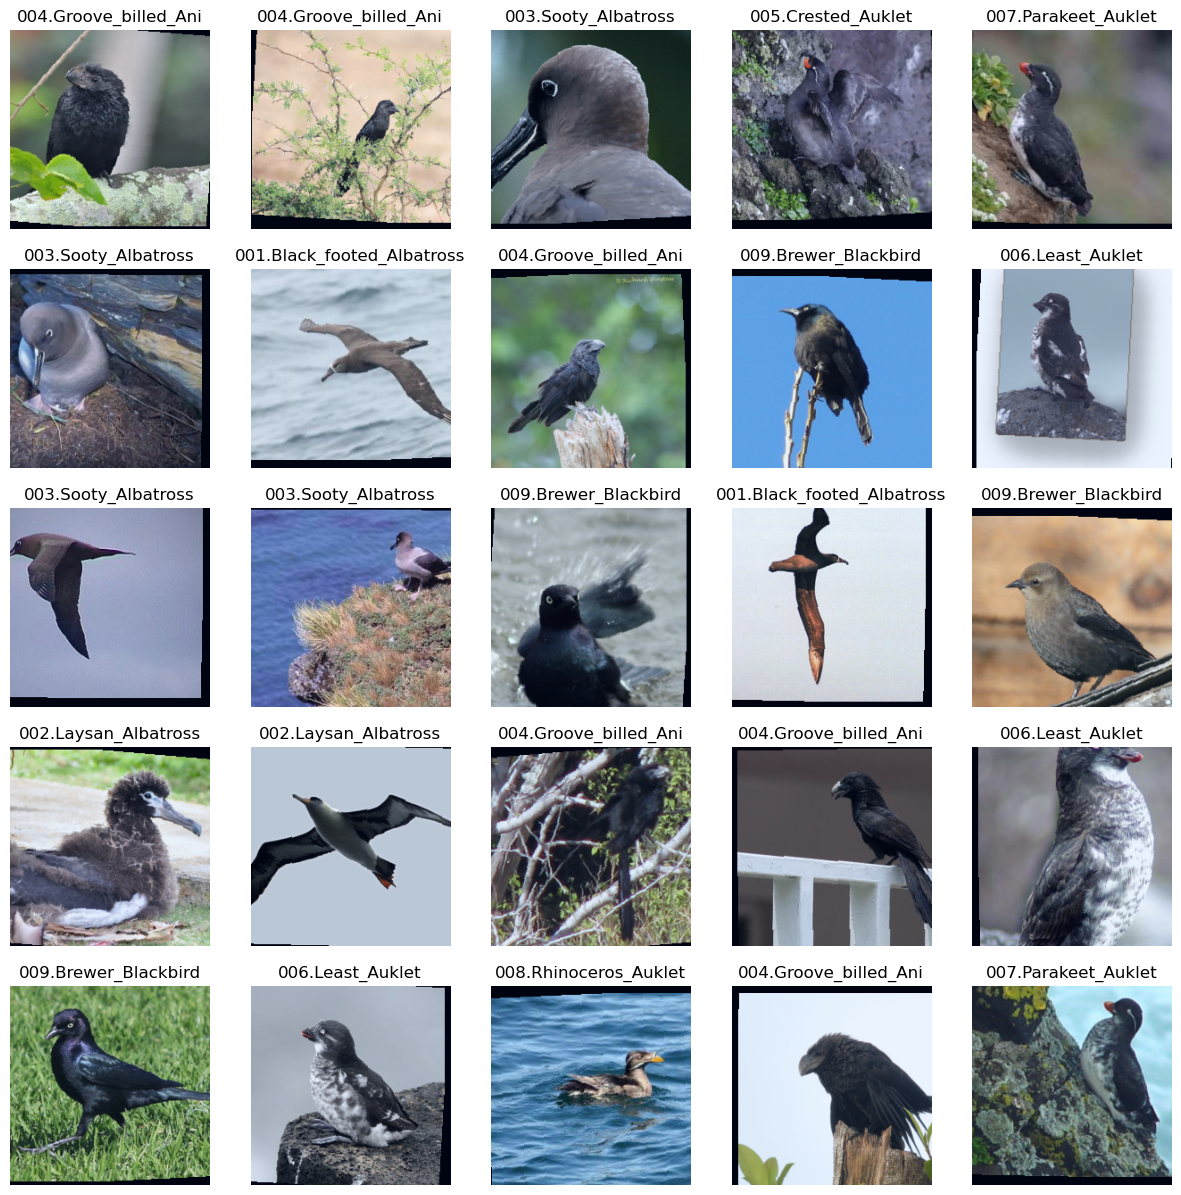

In [11]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

### ÂÆö‰πâÊ®°Âûã

#### Ê®°ÂùóÂåñblock

È¶ñÂÖàÊòØ BasicBlock„ÄÇ

BasicBlock Áî±‰∏§‰∏™ 3x3 Âç∑ÁßØÂ±ÇÁªÑÊàê„ÄÇ Á¨¨‰∏Ä‰∏™ conv1 ÁöÑÊ≠•ÂπÖÈöèÂ±ÇÁöÑ‰∏çÂêåËÄåÂèòÂåñÔºà‰∏Ä‰∏™Âú®Á¨¨‰∏ÄÂ±ÇÔºå‰∏§‰∏™Âú®ÂÖ∂‰ªñÂ±ÇÔºâÔºåËÄåÁ¨¨‰∫å‰∏™ conv2 ÁöÑÊ≠•ÂπÖÂßãÁªà‰∏∫ 1„ÄÇ ÊØè‰∏™Â±ÇÈÉΩÊúâ‰∏Ä‰∏™Â°´ÂÖÖ 1 - ËøôÊÑèÂë≥ÁùÄÂú®Â∞ÜËøáÊª§Âô®Â∫îÁî®‰∫éËæìÂÖ•ÂõæÂÉè‰πãÂâçÔºåÊàë‰ª¨Âú®Êï¥‰∏™ÂõæÂÉèÂë®Âõ¥Ê∑ªÂä†‰∏Ä‰∏™ÂÉèÁ¥†ÔºåÂç≥Âú®ÊØè‰∏™ÈÄöÈÅì‰∏≠‰∏∫Èõ∂„ÄÇ ÊØè‰∏™Âç∑ÁßØÂ±ÇÂêéË∑ü‰∏Ä‰∏™ ReLU ÊøÄÊ¥ªÂáΩÊï∞ÂíåÊâπÈáèÂΩí‰∏ÄÂåñ„ÄÇ

Ê≠£Â¶ÇÂú®‰πãÂâçÁöÑÁ¨îËÆ∞Êú¨‰∏≠ÊèêÂà∞ÁöÑÔºåÂú®ÊøÄÊ¥ªÂáΩÊï∞‰πãÂêéËÄå‰∏çÊòØ‰πãÂâç‰ΩøÁî®ÊâπÈáèÂΩí‰∏ÄÂåñÊõ¥ÊúâÊÑè‰πâ„ÄÇ ÁÑ∂ËÄåÔºåÂéüÂßãÁöÑ ResNet Ê®°ÂûãÂú®ÊøÄÊ¥ª‰πãÂâç‰ΩøÁî®‰∫ÜÊâπÈáèÂΩí‰∏ÄÂåñÔºåÊâÄ‰ª•Êàë‰ª¨Âú®ËøôÈáå‰πüËøôÊ†∑ÂÅö„ÄÇ

downsampleÊó∂ÔºåÊàë‰ª¨ÂêëÊÆãÂ∑ÆË∑ØÂæÑÊ∑ªÂä†‰∏Ä‰∏™Â∏¶Êúâ 1x1 ËøáÊª§Âô®‰∏îÊ≤°ÊúâÂ°´ÂÖÖÁöÑÂç∑ÁßØÂ±Ç„ÄÇ Ëøô‰πüÊúâ‰∏Ä‰∏™ÂèØÂèòÁöÑÊ≠•ÂπÖÔºåÁÑ∂ÂêéÊòØÊâπÂΩí‰∏ÄÂåñ„ÄÇ Ê≠•Èïø‰∏∫ 1 Êó∂Ôºå1x1 ËøáÊª§Âô®‰∏ç‰ºöÊîπÂèòÂõæÂÉèÁöÑÈ´òÂ∫¶ÂíåÂÆΩÂ∫¶ - ÂÆÉÂè™ÊòØÂÖ∑Êúâ out_channels ‰∏™ËøáÊª§Âô®ÔºåÊØè‰∏™ËøáÊª§Âô®ÁöÑÊ∑±Â∫¶‰∏∫ in_channelsÔºåÂç≥ÂÆÉÈÄöËøáÁ∫øÊÄßÊäïÂΩ±Â¢ûÂä†ÂõæÂÉè‰∏≠ÁöÑÈÄöÈÅìÊï∞Èáè ËÄåÂÆûÈôÖ‰∏äÊ†πÊú¨Ê≤°Êúâ‰∏ãÈááÊ†∑„ÄÇ Ê≠•ÂπÖ‰∏∫ 2 Êó∂ÔºåÂÆÉ‰ºöÂ∞ÜÂõæÂÉèÁöÑÈ´òÂ∫¶ÂíåÂÆΩÂ∫¶ÂáèÂ∞ë‰∏§ÂÄçÔºåÂõ†‰∏∫ 1x1 ËøáÊª§Âô®‰ªÖÈÄöËøáÊØèÈöî‰∏Ä‰∏™ÂÉèÁ¥† - ËøôÊ¨°ÂÆÉÂÆûÈôÖ‰∏äÊòØÂØπÂõæÂÉèËøõË°ådownsample‰ª•ÂèäÂØπÈÄöÈÅìËøõË°åÁ∫øÊÄßÊäïÂΩ±„ÄÇ

In [12]:
# Ê®°ÂùóÂåñblock
class BasicBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            # 1*1 ÁöÑÂç∑ÁßØÊù•ÊîπÂèòchannel size, ‰ΩøÊÆãÂ∑ÆÁöÑin channel‰∏éout channelÁõ∏Âêå
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x # iÊòØÂéüÊù•ÁöÑËæìÂÖ•, i ÁöÑchannel‰∏∫in channel
        
        x = self.conv1(x) #3*3Âç∑ÁßØÔºåÊ≠•Èïø1ÔºåÂ°´ÂÖÖ1ÔºåËæìÂÖ•‰∏éËæìÂá∫dimÁõ∏Âêå
        x = self.bn1(x)  # Ê≠£ÂàôÂåñ
        x = self.relu(x) # ÊøÄÊ¥ªÂáΩÊï∞
        
        x = self.conv2(x) #3*3Âç∑ÁßØ
        x = self.bn2(x) # Ê≠£ÂàôÂåñ
        
        if self.downsample is not None:
            i = self.downsample(i) # ‰Ωøi ÁöÑchannel‰∏∫out channel
                        
        x += i  #ÊÆãÂ∑ÆÁõ∏Âä†
        x = self.relu(x)
        
        return x

Êï¥‰∏™ÁöÑÊÆãÂ∑ÆÁ•ûÁªèÁΩëÁªúÔºö

In [13]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config # block = BasicBlock, n_blocks = [2,2,2,2], channels = [64, 128, 256, 512]
        self.in_channels = channels[0] #64
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0]) # Á¨¨‰∏ÄÂ±ÇÊ≠•Èïø‰∏∫1
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2) #‰πãÂêéÊØè‰∏™blockÁ¨¨‰∏ÄÂ±ÇÊ≠•Èïø‰∏∫2ÔºåchannelÊï∞Âä†ÂÄç
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):

        layers = []
        # Â¶ÇÊûúchannelÊï∞Áõ∏ÂêåÔºå‰∏çÁî®downsampleÔºåÂú®ËøûÊé•Êñ∞blockÊó∂Ôºåchannel size ‰∏çÂêå
        if self.in_channels !=  channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample)) # 
        
        for i in range(1, n_blocks):
            layers.append(block( channels, channels)) #blockÁöÑËæìÂÖ•‰∏éËæìÂá∫chanelÁõ∏Âêå

        self.in_channels = channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        # ËæìÂÖ• x: [batch_size,3,224,224] 
        x = self.conv1(x) # in channel 3, out channel 64, 7*7 ,Ê≠•Èïø‰∏∫2Ôºåpadding‰∏∫3ÁöÑÂç∑ÁßØÔºåËæìÂá∫ÂõæÂÉè 64*112*112 (‰∏ÄËà¨Ê≠•Èïø2ÔºåÂõæÂÉèsizeÂáèÂçä)
        x = self.bn1(x) #Ê≠£ÂàôÂåñ
        x = self.relu(x) #ÊøÄÊ¥ªÂáΩÊï∞
        x = self.maxpool(x) #Ê±†ÂåñÂ±Ç 3*3ÔºåÊ≠•Èïø2Ôºåpadding‰∏∫1ÔºåËæìÂá∫ÂõæÂÉè 64*56*56

        x = self.layer1(x) #Á¨¨‰∏Ä‰∏™blockÔºåËæìÂá∫ÂõæÂÉè 64*56*56
        x = self.layer2(x) #Á¨¨‰∫å‰∏™blockÔºåËæìÂá∫ÂõæÂÉè 128*28*28
        x = self.layer3(x) #Á¨¨‰∏â‰∏™blockÔºåËæìÂá∫ÂõæÂÉè 256*14*14
        x = self.layer4(x) #Á¨¨Âõõ‰∏™blockÔºåËæìÂá∫ÂõæÂÉè 512*7*7
        
        x = self.avgpool(x) #Âπ≥ÂùáÊ±†Âåñ ËæìÂá∫ 512*1*1
        h = x.view(x.shape[0], -1) # ÊãâÂπ≥
        x = self.fc(h) #ÂÖ®ËøûÊé•Â±Ç
        
        return x, h

Â∞ÜÊ®°ÂûãÂÆû‰æãÂåñÔºö

In [14]:
OUTPUT_DIM = 10
model = ResNet(resnet18_config, OUTPUT_DIM)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kerne

Áî±‰∫éÊàë‰ª¨Êúâ‰∏Ä‰∏™Áõ∏ÂØπËæÉÂ∞èÁöÑÊï∞ÊçÆÈõÜ - ÊØè‰∏™Á±ªÂà´ÁöÑÁ§∫‰æãÊï∞ÈáèÈùûÂ∏∏Â∞ë - 60 Âº†ÂõæÂÉè - Êàë‰ª¨Â∞Ü‰ΩøÁî®È¢ÑËÆ≠ÁªÉÊ®°Âûã„ÄÇ

Torchvision ‰∏∫ÊâÄÊúâÊ†áÂáÜ ResNet Âèò‰ΩìÊèê‰æõÈ¢ÑËÆ≠ÁªÉÊ®°Âûã„ÄÇ

È¶ñÂÖàÔºåÊàë‰ª¨Âä†ËΩΩÈ¢ÑËÆ≠ÁªÉÁöÑ ResNet Ê®°Âûã„ÄÇ

In [15]:
pretrained_model = models.resnet18(weights='DEFAULT')
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Êàë‰ª¨ÁöÑÊ®°Âûã‰∏éÈ¢ÑËÆ≠ÁªÉÁöÑÊ®°ÂûãÈô§‰∫ÜÊúÄÂêé‰∏ÄÂ±ÇÔºåÂÖ∂ÂÆÉÁöÑÂ±ÇÁªìÊûÑÈÉΩÁõ∏Âêå„ÄÇ

Êàë‰ª¨ÂèØ‰ª•ÁúãÂà∞ÂàÜÁ±ªÁöÑÊúÄÁªàÁ∫øÊÄßÂ±Ç fc ÂÖ∑Êúâ 1000 Áª¥ËæìÂá∫ÔºåÂõ†‰∏∫ÂÆÉÊòØÂú®ÂÖ∑Êúâ 1000 ‰∏™Á±ªÁöÑ ImageNet Êï∞ÊçÆÈõÜ‰∏äËøõË°åÈ¢ÑËÆ≠ÁªÉÁöÑ„ÄÇ

ÁÑ∂ËÄåÔºåÊàë‰ª¨ÁöÑÊï∞ÊçÆÈõÜÂè™Êúâ 10 ‰∏™Á±ªÔºåÂõ†Ê≠§Êàë‰ª¨È¶ñÂÖàÂàõÂª∫‰∏Ä‰∏™ÂÖ∑ÊúâÊâÄÈúÄÁª¥Â∫¶ÁöÑÊñ∞Á∫øÊÄßÂ±Ç„ÄÇ

ÁÑ∂ÂêéÔºåÊàë‰ª¨Áî®Êàë‰ª¨Ëá™Â∑±ÁöÑ„ÄÅÈöèÊú∫ÂàùÂßãÂåñÁöÑÁ∫øÊÄßÂ±ÇÊõøÊç¢È¢ÑËÆ≠ÁªÉÊ®°ÂûãÁöÑÁ∫øÊÄßÂ±Ç„ÄÇ

Ê≥®ÊÑèÔºöÂç≥‰ΩøÊàë‰ª¨ÁöÑÊï∞ÊçÆÈõÜÊúâ 1000 ‰∏™Á±ªÔºå‰∏é ImageNet Áõ∏ÂêåÔºåÊàë‰ª¨‰ªçÁÑ∂‰ºöÂà†Èô§Á∫øÊÄßÂ±ÇÂπ∂Áî®ÈöèÊú∫ÂàùÂßãÂåñÁöÑÂ±ÇÊõøÊç¢ÂÆÉÔºåÂõ†‰∏∫Êàë‰ª¨ÁöÑÁ±ª‰∏é ImageNet ÁöÑÁ±ª‰∏çÁõ∏Á≠â„ÄÇ

In [16]:
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc

...ÁÑ∂ÂêéÊàë‰ª¨Â∞ÜÈ¢ÑËÆ≠ÁªÉÊ®°ÂûãÁöÑÂèÇÊï∞ÔºàÂú® PyTorch ‰∏≠Áß∞‰∏∫ state_dictÔºâÂä†ËΩΩÂà∞Êàë‰ª¨ÁöÑÊ®°Âûã‰∏≠„ÄÇ

Ëøô‰πüÊòØ‰∏Ä‰∏™ÂæàÂ•ΩÁöÑÂÅ•ÂÖ®ÊÄßÊ£ÄÊü•Ôºå‰ª•Á°Æ‰øùÊàë‰ª¨ÁöÑ ResNet Ê®°Âûã‰∏é torchvision ‰ΩøÁî®ÁöÑÊ®°ÂûãÁõ∏ÂåπÈÖç„ÄÇ

In [17]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

Êàë‰ª¨ËøòÂèØ‰ª•ÁúãÂà∞Êàë‰ª¨Ê®°Âûã‰∏≠ÁöÑÂèÇÊï∞Êï∞Èáè‚Äî‚ÄîÊ≥®ÊÑè ResNet18 Âè™ÊúâÁ∫¶ 11M ÁöÑÂèÇÊï∞ÔºåËÄå VGG11 ÁöÑÁ∫¶ 129M„ÄÇ Ëøô‰∏ªË¶ÅÊòØÁî±‰∫é‰∏çÂÜçÁî®È´òÁª¥Á∫øÊÄßÂ±ÇÔºåËøô‰∫õÂ±ÇÂ∑≤Ë¢´ÂèÇÊï∞Êõ¥ÊúâÊïàÁöÑÂç∑ÁßØÂ±ÇÊâÄÂèñ‰ª£„ÄÇ

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,181,642 trainable parameters


### ËÆ≠ÁªÉÊ®°Âûã

Êé•‰∏ãÊù•Êàë‰ª¨Â∞ÜÁªßÁª≠ËÆ≠ÁªÉÊàë‰ª¨ÁöÑÊ®°Âûã„ÄÇ ‰∏é‰πãÂâçÁöÑÁ¨îËÆ∞‰∏ÄÊ†∑ÔºåÊàë‰ª¨Â∞Ü‰ΩøÁî®Â≠¶‰π†ÁéáÊü•ÊâæÂô®‰∏∫Êàë‰ª¨ÁöÑÊ®°ÂûãËÆæÁΩÆÂêàÈÄÇÁöÑÂ≠¶‰π†Áéá„ÄÇ

Êàë‰ª¨È¶ñÂÖàÂàùÂßãÂåñ‰∏Ä‰∏™Â≠¶‰π†ÁéáÈùûÂ∏∏‰ΩéÁöÑ‰ºòÂåñÂô®ÔºåÂÆö‰πâ‰∏Ä‰∏™ÊçüÂ§±ÂáΩÊï∞ÔºàÂáÜÂàôÔºâÂíåËÆæÂ§áÔºåÁÑ∂ÂêéÂ∞ÜÊ®°ÂûãÂíåÊçüÂ§±ÂáΩÊï∞ÊîæÂú®ËÆæÂ§á‰∏ä„ÄÇ

In [19]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

Êé•‰∏ãÊù•ÊòØÂ≠¶‰π†ÁéáÊü•ÊâæÂô®„ÄÇ Ê≠§Â§ÑÁöÑ‰ª£Á†ÅÂèñËá™‰ºòÁßÄÁöÑ pytorch-lr-finder ÁöÑÁ≤æÁÆÄÁâàÂíåÁï•ÂæÆ‰øÆÊîπÁâà„ÄÇ

Ê≥®ÊÑèÔºöÂ≠¶‰π†ÁéáÊü•ÊâæÂô®‰∏éÂÖ∂ËØ¥ÊòØ‰∏ÄÈó®ÁßëÂ≠¶Ôºå‰∏çÂ¶ÇËØ¥ÊòØ‰∏ÄÈó®Ëâ∫ÊúØ„ÄÇ ÂÆÉ‰∏ç‰ºöÊâæÂà∞Á≤æÁ°ÆÂà∞Â∞èÊï∞ÁÇπÂêé 10 ‰ΩçÁöÑÂ≠¶‰π†ÁéáÔºåËøôÂ∞ÜÂßãÁªà‰∏∫Êàë‰ª¨Êèê‰æõ 100% ÁöÑÂáÜÁ°ÆÁéá‚Äî‚Äî‰ΩÜÂÆÉÈÄöÂ∏∏ÊØîÂá≠Á©∫ÈÄâÊã©‰∏Ä‰∏™Â≠¶‰π†ÁéáË¶ÅÂ•Ω„ÄÇ

ÊúÄÂ∏∏Áî®ÁöÑ‰ºòÂåñÂô®ÊòØ Adam„ÄÇ Adam ÁöÑÈªòËÆ§Â≠¶‰π†ÁéáÈÄöÂ∏∏ÊòØ‰∏Ä‰∏™‰∏çÈîôÁöÑÈÄâÊã©Ôºå‰ΩÜÊòØÔºåÂ∞±ÂÉèÊàë‰ª¨ÊâãÂä®ÂàùÂßãÂåñÂèÇÊï∞‰ª•ÊΩúÂú®Âú∞ÊèêÈ´òÊÄßËÉΩÁöÑÊñπÂºè‰∏ÄÊ†∑ÔºåÊàë‰ª¨ÂèØ‰ª•Â∞ùËØïÊâãÂä®ËÆ°ÁÆóÊúÄ‰Ω≥Â≠¶‰π†Áéá„ÄÇ

Â≠¶‰π†ÁéáÊü•ÊâæÂô®Â¶Ç‰ΩïÂ∑•‰ΩúÔºü Êàë‰ª¨ÂêëÂèëÁé∞ËÄÖÊèê‰æõÊàë‰ª¨ÊÉ≥Ë¶Å‰ΩøÁî®ÁöÑÊ®°Âûã„ÄÅ‰ºòÂåñÂô®ÂíåÊ†áÂáÜ„ÄÇ ÁÑ∂ËÄåÔºåÊàë‰ª¨ÁªôÂÆÉ‰∏Ä‰∏™Â≠¶‰π†ÁéáÊØîÊàë‰ª¨È¢ÑÊúü‰ΩøÁî®ÁöÑ‰ΩéÂæóÂ§öÁöÑ‰ºòÂåñÂô®„ÄÇ ÁÑ∂ÂêéÔºåÊàë‰ª¨Ê†πÊçÆËÆ≠ÁªÉÈõÜ‰∏≠ÁöÑÊâπÈáèÊï∞ÊçÆËÆ≠ÁªÉÊ®°Âûã‚Äî‚ÄîËÆ°ÁÆóÊçüÂ§±Âπ∂Êõ¥Êñ∞ÂèÇÊï∞„ÄÇ Âú®ÊØèÊâπÊ¨°‰πãÂêéÔºåÊàë‰ª¨Â∞ÜÂ≠¶‰π†Áéá‰ªéÊúÄÂàùÁöÑÊûÅ‰ΩéÂ≠¶‰π†ÁéáÂëàÊåáÊï∞Â¢ûÂä†Âà∞Êàë‰ª¨Áü•ÈÅì‰ºöËøáÈ´òÁöÑÂ≠¶‰π†Áéá„ÄÇ ÈáçÂ§çÊ≠§ËøáÁ®ãÔºåÁõ¥Âà∞Êàë‰ª¨ÁöÑÊçüÂ§±ÂèëÁîüÂàÜÊ≠ßÔºàËææÂà∞ÊúÄ‰Ω≥ÊçüÂ§±ÁöÑ 5 ÂÄç‰ª•‰∏äÔºâÊàñËææÂà∞Êàë‰ª¨ÂÆö‰πâÁöÑÊúÄÂ§ßÂ≠¶‰π†Áéá„ÄÇ

Âú®ÊØè‰∏™ÊâπÊ¨°‰∏≠ÔºåÊàë‰ª¨ÈÉΩËÆ∞ÂΩï‰∫ÜÂ≠¶‰π†ÁéáÂíåËØ•ÊâπÊ¨°ÁöÑÊçüÂ§±„ÄÇ ÈÄöËøáÂ∞ÜÂÆÉ‰ª¨Áõ∏‰∫íÊØîËæÉÔºåÊàë‰ª¨ÂèØ‰ª•ÊâæÂà∞ÂêàÈÄÇÁöÑÂ≠¶‰π†Áéá‚Äî‚Äî‰ΩÜÁ®çÂêé‰ºöËØ¶ÁªÜ‰ªãÁªçÂ¶Ç‰ΩïÂÅöÂà∞Ëøô‰∏ÄÁÇπ„ÄÇ

ËÆ°ÁÆóÂá∫ÁöÑÊçüÂ§±ÈÄöÂ∏∏ÈùûÂ∏∏ÂòàÊùÇÔºåÂõ†Ê≠§Êàë‰ª¨ÂÆûÈôÖ‰∏ä‰øùÂ≠ò‰∫ÜËÆ°ÁÆóÂá∫ÁöÑÊçüÂ§±ÁöÑÊåáÊï∞Âä†ÊùÉÂπ≥ÂùáÂÄº„ÄÇ

Êàë‰ª¨ËøòÊÉ≥‰ΩøÁî®Êàë‰ª¨ÁöÑÂàùÂßãÂåñÂèÇÊï∞ÔºåËÄå‰∏çÊòØÂú®ÊâßË°åÂ≠¶‰π†ÁéáÊü•ÊâæÂô®Êó∂ÈÄöËøáÂçáÁ∫ßÂèÇÊï∞Ëé∑ÂæóÁöÑÂèÇÊï∞„ÄÇ Âõ†Ê≠§ÔºåÊàë‰ª¨Âú®ÂàùÂßãÂåñÊü•ÊâæÂô®Êó∂Â∞ÜÊ®°ÂûãÂèÇÊï∞‰øùÂ≠òÂà∞Á£ÅÁõòÔºåÁÑ∂ÂêéÂú® range_test ÂáΩÊï∞ËøîÂõû‰πãÂâçÈÄöËøá‰ªéÁ£ÅÁõòÂä†ËΩΩÂàùÂßãÂÄºÂ∞ÜÂÆÉ‰ª¨ÈáçÁΩÆ‰∏∫Êàë‰ª¨ÊÉ≥Ë¶ÅÁöÑÂàùÂßãÂåñÂèÇÊï∞„ÄÇ

In [20]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

Êé•‰∏ãÊù•ÔºåÊàë‰ª¨Â∞Ü‰ΩøÁî®LRFinder„ÄÇ

Êàë‰ª¨È¶ñÂÖà‰ΩøÁî®Ê®°Âûã„ÄÅ‰ºòÂåñÂô®„ÄÅÊçüÂ§±ÂáΩÊï∞ÂíåËÆæÂ§áÂàõÂª∫Êü•ÊâæÂô®Á±ªÁöÑÂÆû‰æã„ÄÇ ÁÑ∂ÂêéÊàë‰ª¨Â∞Ü range_test ‰∏éËÆ≠ÁªÉËø≠‰ª£Âô®„ÄÅÊúÄÂ§ßÂ≠¶‰π†ÁéáÂíåÊàë‰ª¨Ë¶Å‰ΩøÁî®ÁöÑËø≠‰ª£Ê¨°Êï∞‰∏ÄËµ∑‰ΩøÁî®„ÄÇ

In [21]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


Êé•‰∏ãÊù•ÔºåÊàë‰ª¨ÂèØ‰ª•ÁªòÂà∂Â≠¶‰π†Áéá‰∏éÊçüÂ§±ÁöÑÂÖ≥Á≥ªÂõæ„ÄÇ

ÈöèÁùÄÊàë‰ª¨ÁöÑÂ≠¶‰π†ÁéáÂëàÊåáÊï∞Á∫ßÂ¢ûÈïøÔºåÊàë‰ª¨Â∏åÊúõÂ∞ÜÂÖ∂ÁªòÂà∂Âú®ÂØπÊï∞Â∞∫Â∫¶‰∏ä„ÄÇ Êàë‰ª¨‰πü‰∏çÊÉ≥ÁªòÂà∂ÊúÄÂêéÂá†‰∏™ÂÄºÔºåÂõ†‰∏∫ÂÆÉ‰ª¨ÈÄöÂ∏∏ÊòØÊçüÂ§±ÈùûÂ∏∏È´òÁöÑÂú∞ÊñπÔºåÂπ∂‰∏îÂæàÈöæËØ¶ÁªÜÊ£ÄÊü•ÂõæË°®„ÄÇ ÊÇ®‰πüÂèØ‰ª•Ë∑≥ËøáÂâçÂá†‰∏™ÂÄºÔºåÂõ†‰∏∫ÈÇ£ÈáåÊ≤°ÊúâÂèëÁîü‰ªª‰ΩïÊúâË∂£ÁöÑ‰∫ãÊÉÖ„ÄÇ

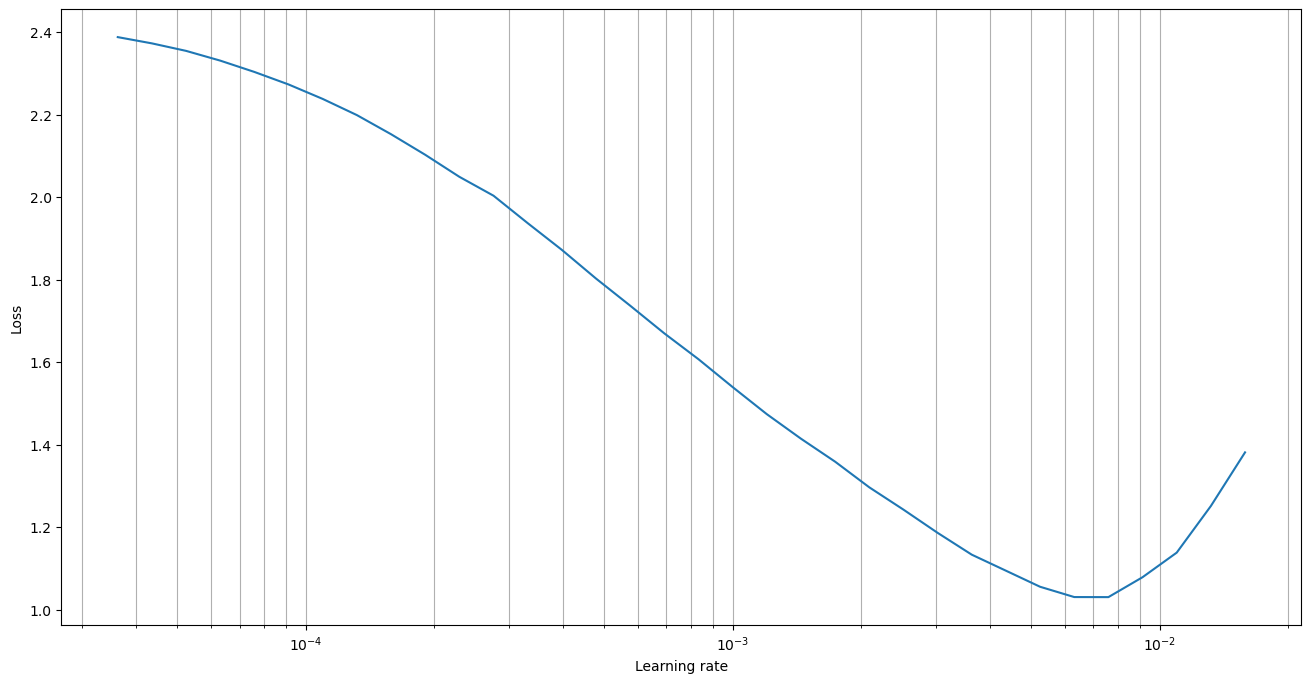

In [22]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

Êàë‰ª¨ÂèØ‰ª•ÁúãÂà∞ÊçüÂ§±Âú®Â≠¶‰π†Áéá‰∏∫Â§ßÁ∫¶1*10‚àí2Â∑¶Âè≥ËææÂà∞ÊúÄÂ∞èÂÄº

Âú®ËøôÈáåÈÄâÊã©ÁöÑÊØîËæÉÂ•ΩÁöÑÂ≠¶‰π†ÁéáÊòØÊúÄÈô°Â≥≠ÁöÑÂêë‰∏ãÊõ≤Á∫øÁöÑ‰∏≠Èó¥‚Äî‚ÄîÂ§ßÁ∫¶ÊòØ 1*10‚àí3

ÁÑ∂ÂêéÔºåÊàë‰ª¨ÂèØ‰ª•‰ΩøÁî®Âà§Âà´ÂºèÂæÆË∞ÉÊù•ËÆæÁΩÆÊ®°ÂûãÁöÑÂ≠¶‰π†Áéá‚Äî‚ÄîËøôÊòØ‰∏ÄÁßçÁî®‰∫éËøÅÁßªÂ≠¶‰π†ÁöÑÊäÄÊúØÔºåÊ®°Âûã‰∏≠ÂêéÊúüÁöÑÂ±ÇÊØîÊó©ÊúüÁöÑÂ±ÇÂÖ∑ÊúâÊõ¥È´òÁöÑÂ≠¶‰π†Áéá„ÄÇ

Êàë‰ª¨‰ΩøÁî®Â≠¶‰π†ÁéáÊü•ÊâæÂô®ÊâæÂà∞ÁöÑÂ≠¶‰π†Áéá‰Ωú‰∏∫ÊúÄÂ§ßÂ≠¶‰π†Áéá‚Äî‚ÄîÂú®ÊúÄÂêé‰∏ÄÂ±Ç‰ΩøÁî®‚Äî‚ÄîËÄåÂÖ∂‰ΩôÂ±ÇÁöÑÂ≠¶‰π†ÁéáËæÉ‰ΩéÔºåÂêëËæìÂÖ•ÈÄêÊ∏êÈôç‰Ωé„ÄÇ

In [23]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

Êé•‰∏ãÊù•ÔºåÊàë‰ª¨ËÆæÁΩÆÂ≠¶‰π†ÁéáË∞ÉÂ∫¶Âô®„ÄÇ Â≠¶‰π†ÁéáË∞ÉÂ∫¶Á®ãÂ∫è‰ºöÂú®Ê®°ÂûãËÆ≠ÁªÉÊó∂Âä®ÊÄÅÊîπÂèòÂ≠¶‰π†Áéá„ÄÇ Êàë‰ª¨Â∞Ü‰ΩøÁî®ÂçïÂë®ÊúüÂ≠¶‰π†ÁéáË∞ÉÂ∫¶Âô®Ôºå‰ΩÜÊòØ PyTorch ‰∏≠Êèê‰æõ‰∫ÜËÆ∏Â§öË∞ÉÂ∫¶Âô®„ÄÇ

ÂçïÂë®ÊúüÂ≠¶‰π†ÁéáË∞ÉÂ∫¶Âô®‰ªé‰∏Ä‰∏™Â∞èÁöÑÂàùÂßãÂ≠¶‰π†ÁéáÂºÄÂßãÔºåÈÄêÊ∏êÂ¢ûÂä†Âà∞ÊúÄÂ§ßÂÄº‚Äî‚ÄîÊàë‰ª¨ÁöÑÂ≠¶‰π†ÁéáÊü•ÊâæÂô®ÊâæÂà∞ÁöÑÂÄº‚Äî‚ÄîÁÑ∂ÂêéÂÆÉÊÖ¢ÊÖ¢Âú∞Â∞ÜÂ≠¶‰π†ÁéáÈôç‰ΩéÂà∞Â∞è‰∫éÂàùÂßãÂ≠¶‰π†ÁéáÁöÑÊúÄÁªàÂÄº„ÄÇ ËØ•Â≠¶‰π†ÁéáÂú®ÊØè‰∏™ÂèÇÊï∞Êõ¥Êñ∞Ê≠•È™§ÂêéÊõ¥Êñ∞ÔºåÂç≥Âú®ÊØè‰∏™ËÆ≠ÁªÉÊâπÊ¨°ÂêéÊõ¥Êñ∞„ÄÇ 

In [24]:
EPOCHS = 20
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

Êàë‰ª¨Ë¶ÅÂÆûÁé∞ÁöÑÂè¶‰∏Ä‰ª∂‰∫ãÊòØ top-k ÂáÜÁ°ÆÊÄß„ÄÇ Êàë‰ª¨ÁöÑ‰ªªÂä°ÊòØÂ∞ÜÂõæÂÉèÂàÜÁ±ª‰∏∫ 10 ÁßçÈ∏üÁ±ª‰∏≠ÁöÑ‰∏ÄÁßçÔºå‰ΩÜÊòØÂÖ∂‰∏≠‰∏Ä‰∫õÁ±ªÂà´ÁúãËµ∑Êù•ÈùûÂ∏∏Áõ∏‰ººÔºå‰∫∫Á±ªÁîöËá≥ÂæàÈöæÊ≠£Á°ÆÊ†áËÆ∞ÂÆÉ‰ª¨„ÄÇ ÈÇ£‰πàÔºå‰πüËÆ∏Êàë‰ª¨Âú®ËÆ°ÁÆóÂáÜÁ°ÆÁéáÊó∂Â∫îËØ•Êõ¥ÂÆΩÊùæ‰∏Ä‰∫õÔºü

Ëß£ÂÜ≥Ëøô‰∏™ÈóÆÈ¢òÁöÑ‰∏ÄÁßçÊñπÊ≥ïÊòØ‰ΩøÁî® top-k ÂáÜÁ°ÆÁéáÔºåÂ¶ÇÊûúÊ≠£Á°ÆÁöÑÊ†áÁ≠æÂú® top-k È¢ÑÊµã‰∏≠ÔºåÂàôÈ¢ÑÊµãË¢´Ê†áËÆ∞‰∏∫Ê≠£Á°ÆÔºåËÄå‰∏ç‰ªÖ‰ªÖÊòØÁ¨¨‰∏Ä‰∏™„ÄÇ Êàë‰ª¨ÁöÑ calculate_topk_accuracy ÂáΩÊï∞ËÆ°ÁÆó top-1 Á≤æÂ∫¶‰ª•Âèä top-k Á≤æÂ∫¶ÔºåÂÖ∂‰∏≠ ùëò=5„ÄÇ

In [25]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

Êé•‰∏ãÊù•ÊòØËÆ≠ÁªÉÂäüËÉΩ„ÄÇ ËøôÁ±ª‰ºº‰∫éÊâÄÊúâ‰ª•ÂâçÁöÑÁ¨îËÆ∞Êú¨Ôºå‰ΩÜÂ¢ûÂä†‰∫ÜË∞ÉÂ∫¶Á®ãÂ∫èÂíåËÆ°ÁÆó/ËøîÂõû top-k Á≤æÂ∫¶„ÄÇ

Ë∞ÉÂ∫¶Á®ãÂ∫èÈÄöËøáË∞ÉÁî® scheduler.step() ËøõË°åÊõ¥Êñ∞„ÄÇ ËøôÂ∫îËØ•ÊÄªÊòØÂú® optimizer.step() ‰πãÂêéË∞ÉÁî®ÔºåÂê¶ÂàôË∞ÉÂ∫¶Á®ãÂ∫èÁöÑÁ¨¨‰∏Ä‰∏™Â≠¶‰π†ÁéáÂ∞ÜË¢´Ë∑≥Ëøá„ÄÇ

Âπ∂‰∏çÊòØÊâÄÊúâÁöÑË∞ÉÂ∫¶Âô®ÈÉΩÈúÄË¶ÅÂú®ÊØè‰∏™ËÆ≠ÁªÉÊâπÊ¨°‰πãÂêéË∞ÉÁî®ÔºåÊúâ‰∫õÂè™Âú®ÊØè‰∏™ epoch ‰πãÂêéË∞ÉÁî®„ÄÇ Âú®ÈÇ£ÁßçÊÉÖÂÜµ‰∏ãÔºåË∞ÉÂ∫¶Á®ãÂ∫è‰∏çÈúÄË¶Å‰º†ÈÄíÁªôËÆ≠ÁªÉÂáΩÊï∞ÔºåÂèØ‰ª•Âú®‰∏ªËÆ≠ÁªÉÂæ™ÁéØ‰∏≠Ë∞ÉÁî®„ÄÇ

In [26]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

Êé•‰∏ãÊù•ÊòØËÆ≠ÁªÉÂäüËÉΩ„ÄÇ ËøôÁ±ª‰ºº‰∫éÊâÄÊúâ‰ª•ÂâçÁöÑÁ¨îËÆ∞Ôºå‰ΩÜÂ¢ûÂä†‰∫Ütop-k Á≤æÂ∫¶„ÄÇ

Ë∞ÉÂ∫¶Á®ãÂ∫èÈÄöËøáË∞ÉÁî® scheduler.step() ËøõË°åÊõ¥Êñ∞„ÄÇ ËøôÂ∫îËØ•ÊÄªÊòØÂú® optimizer.step() ‰πãÂêéË∞ÉÁî®ÔºåÂê¶ÂàôË∞ÉÂ∫¶Á®ãÂ∫èÁöÑÁ¨¨‰∏Ä‰∏™Â≠¶‰π†ÁéáÂ∞ÜË¢´Ë∑≥Ëøá„ÄÇ

Âπ∂‰∏çÊòØÊâÄÊúâÁöÑË∞ÉÂ∫¶Âô®ÈÉΩÈúÄË¶ÅÂú®ÊØè‰∏™ËÆ≠ÁªÉÊâπÊ¨°‰πãÂêéË∞ÉÁî®ÔºåÊúâ‰∫õÂè™Âú®ÊØè‰∏™ epoch ‰πãÂêéË∞ÉÁî®„ÄÇ Âú®ÈÇ£ÁßçÊÉÖÂÜµ‰∏ãÔºåË∞ÉÂ∫¶Á®ãÂ∫è‰∏çÈúÄË¶Å‰º†ÈÄíÁªôËÆ≠ÁªÉÂáΩÊï∞ÔºåÂèØ‰ª•Âú®‰∏ªËÆ≠ÁªÉÂæ™ÁéØ‰∏≠Ë∞ÉÁî®„ÄÇ

In [27]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

Êé•‰∏ãÊù•Ôºå‰∏Ä‰∏™Â∞èÁöÑËæÖÂä©ÂáΩÊï∞ÂëäËØâÊàë‰ª¨‰∏Ä‰∏™epochËä±‰∫ÜÂ§öÈïøÊó∂Èó¥„ÄÇ 

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we can train our model!

In [29]:
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 2.333 | Train Acc @1:  12.07% | Train Acc @5:  56.04%
	Valid Loss: 2.239 | Valid Acc @1:  22.93% | Valid Acc @5:  60.63%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 1.811 | Train Acc @1:  48.14% | Train Acc @5:  86.98%
	Valid Loss: 1.592 | Valid Acc @1:  51.43% | Valid Acc @5:  91.13%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 1.020 | Train Acc @1:  80.52% | Train Acc @5:  99.48%
	Valid Loss: 0.944 | Valid Acc @1:  67.93% | Valid Acc @5:  97.04%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.454 | Train Acc @1:  91.64% | Train Acc @5: 100.00%
	Valid Loss: 0.604 | Valid Acc @1:  74.63% | Valid Acc @5:  97.04%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.245 | Train Acc @1:  94.35% | Train Acc @5: 100.00%
	Valid Loss: 0.630 | Valid Acc @1:  76.19% | Valid Acc @5:  97.83%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.105 | Train Acc @1:  99.22% | Train Acc @5: 100.00%
	Valid Loss: 0.502 | Valid Acc @1:  78.36% | Valid Acc @5:  97.83%
Epoch: 07 | Epoc

ÊµãËØïÂáÜÁ°ÆÂ∫¶Áï•‰Ωé‰∫éÈ™åËØÅÂáÜÁ°ÆÂ∫¶Ôºå‰ΩÜÊ≤°Êúâ‰ΩéÂà∞Êàë‰ª¨Â∫îËØ•ÊãÖÂøÉÁöÑÁ®ãÂ∫¶„ÄÇ

In [30]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

Test Loss: 0.447 | Test Acc @1:  87.37% | Test Acc @5:  98.94%


ËøôÈáåÊàë‰ª¨ÂØπÊØî‰∏ãÁî®‰∫ÜÂ≠¶‰π†ÁéáschedulerÂíåÊ≤°Áî®ÁöÑÂ∑ÆÂà´Ôºö

In [31]:
model.load_state_dict(pretrained_model.state_dict())
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

optimizer = optim.Adam(params, lr = FOUND_LR)
for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 2.471 | Train Acc @1:   7.03% | Train Acc @5:  42.69%
	Valid Loss: 2.552 | Valid Acc @1:   7.64% | Valid Acc @5:  40.22%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 2.461 | Train Acc @1:   7.35% | Train Acc @5:  44.95%
	Valid Loss: 2.547 | Valid Acc @1:   8.25% | Valid Acc @5:  34.92%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 2.463 | Train Acc @1:   5.87% | Train Acc @5:  42.34%
	Valid Loss: 2.546 | Valid Acc @1:   6.86% | Valid Acc @5:  33.19%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 2.448 | Train Acc @1:   9.67% | Train Acc @5:  43.12%
	Valid Loss: 2.542 | Valid Acc @1:   4.52% | Valid Acc @5:  34.75%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 2.443 | Train Acc @1:  10.48% | Train Acc @5:  49.58%
	Valid Loss: 2.542 | Valid Acc @1:   4.52% | Valid Acc @5:  32.40%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 2.459 | Train Acc @1:   8.89% | Train Acc @5:  42.95%
	Valid Loss: 2.540 | Valid Acc @1:   4.52% | Valid Acc @5:  36.14%
Epoch: 07 | Epoc